In [75]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import pandas as pd
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.metrics import roc_curve, auc

In [61]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json
!pip install kaggle





In [3]:
!kaggle datasets download -d mdwaquarazam/agricultural-crops-image-classification
!unzip agricultural-crops-image-classification.zip -d ./agricultural_crops

Dataset URL: https://www.kaggle.com/datasets/mdwaquarazam/agricultural-crops-image-classification
License(s): CC0-1.0
 99% 78.0M/79.0M [00:00<00:00, 143MB/s]
100% 79.0M/79.0M [00:00<00:00, 124MB/s]
Archive:  agricultural-crops-image-classification.zip
  inflating: ./agricultural_crops/Agricultural-crops/Cherry/image15.jpeg  
  inflating: ./agricultural_crops/Agricultural-crops/Cherry/image16.jpeg  
  inflating: ./agricultural_crops/Agricultural-crops/Cherry/image17.jpeg  
  inflating: ./agricultural_crops/Agricultural-crops/Cherry/image18.jpeg  
  inflating: ./agricultural_crops/Agricultural-crops/Cherry/image20.jpeg  
  inflating: ./agricultural_crops/Agricultural-crops/Cherry/image21.jpeg  
  inflating: ./agricultural_crops/Agricultural-crops/Cherry/image22.jpeg  
  inflating: ./agricultural_crops/Agricultural-crops/Cherry/image24.jpeg  
  inflating: ./agricultural_crops/Agricultural-crops/Cherry/image25.jpeg  
  inflating: ./agricultural_crops/Agricultural-crops/Cherry/image27.jpeg 

In [62]:
!ls -R ./agricultural_crops

./agricultural_crops:
Agricultural-crops  subset_dataset

./agricultural_crops/Agricultural-crops:
 almond     coconut	        jowar	      papaya		     sunflower
 banana     Coffee-plant        jute	     'Pearl_millet(bajra)'   tea
 cardamom   cotton	        Lemon	      pineapple		     Tobacco-plant
 Cherry     Cucumber	        maize	      rice		     tomato
 chilli    'Fox_nut(Makhana)'   mustard-oil   soyabean		    'vigna-radiati(Mung)'
 clove	    gram	        Olive-tree    sugarcane		     wheat

./agricultural_crops/Agricultural-crops/almond:
'image (10).jpg'  'image (15).jpg'  'image (1).jpg'  'image (3).jpg'  'image (6).jpg'
'image (11).jpg'  'image (16).jpg'  'image (1).png'  'image (3).png'  'image (7).jpg'
'image (12).jpg'  'image (17).jpg'  'image (2).jpg'  'image (4).jpg'  'image (8).jpg'
'image (14).jpg'  'image (18).jpg'  'image (2).png'  'image (5).jpg'

./agricultural_crops/Agricultural-crops/banana:
'image (10).jpg'  'image (19).jpg'  'image (23).jpg'  'image (29).jpg'	'i

In [63]:
base_folder = './agricultural_crops'

class_names = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]

print("Class names:", class_names)


Class names: ['subset_dataset', 'Agricultural-crops']


In [64]:
base_folder = './agricultural_crops/Agricultural-crops'

subset_folder = 'subset_dataset'
os.makedirs(subset_folder, exist_ok=True)

classes = ['Cherry', 'banana', 'coconut', 'chilli', 'Cucumber']
print(classes)

['Cherry', 'banana', 'coconut', 'chilli', 'Cucumber']


In [65]:
image_size = (224, 224)
batch_size = 10

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    base_folder,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 802 files belonging to 30 classes.
Using 642 files for training.
Using 160 files for validation.


In [71]:

image_filenames = [f for f in os.listdir(base_folder) if f.endswith('.png')]

num_images = len(image_filenames)


print(f"Number of images: {num_images}")

print(f"Number of training images: {len(train_ds)}")
print(f"Number of validation images: {len(val_ds)}")


Number of images: 0
Number of training images: 12
Number of validation images: 3


In [67]:
def create_subset(base_folder, classes, max_images_per_class=100):
    subset_folder = 'subset_dataset'
    os.makedirs(subset_folder, exist_ok=True)

    for folder_name in classes:
        src_folder = os.path.join(base_folder, folder_name)
        dest_folder = os.path.join(subset_folder, folder_name)
        os.makedirs(dest_folder, exist_ok=True)

        if not os.path.exists(src_folder):
            print(f"Source folder not found: {src_folder}")
            continue

        images = os.listdir(src_folder)
        for i, fname in enumerate(images):
            if i >= max_images_per_class:
                break
            src_file = os.path.join(src_folder, fname)
            dest_file = os.path.join(dest_folder, fname)
            shutil.copy(src_file, dest_file)

base_folder = './agricultural_crops/Agricultural-crops'
classes = ['Cherry', 'banana', 'coconut', 'chilli', 'Cucumber']

create_subset(base_folder, classes)


In [68]:
def remove_small_images(base_folder, min_size=(100, 100)):
    num_removed = 0
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        if os.path.isdir(folder_path):
            for fname in os.listdir(folder_path):
                fpath = os.path.join(folder_path, fname)
                if os.path.isfile(fpath):
                    try:
                        with Image.open(fpath) as img:
                            width, height = img.size
                            if width < min_size[0] or height < min_size[1]:
                                os.remove(fpath)
                                num_removed += 1
                    except Exception as e:
                        print(f"Cannot open {fname}: {e}")
    print(f"Total images removed: {num_removed}")

remove_small_images('agricultural_crops')


Total images removed: 0


In [69]:
batch_size = 10
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    subset_folder,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    subset_folder,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)



Found 142 files belonging to 5 classes.
Using 114 files for training.
Found 142 files belonging to 5 classes.
Using 28 files for validation.


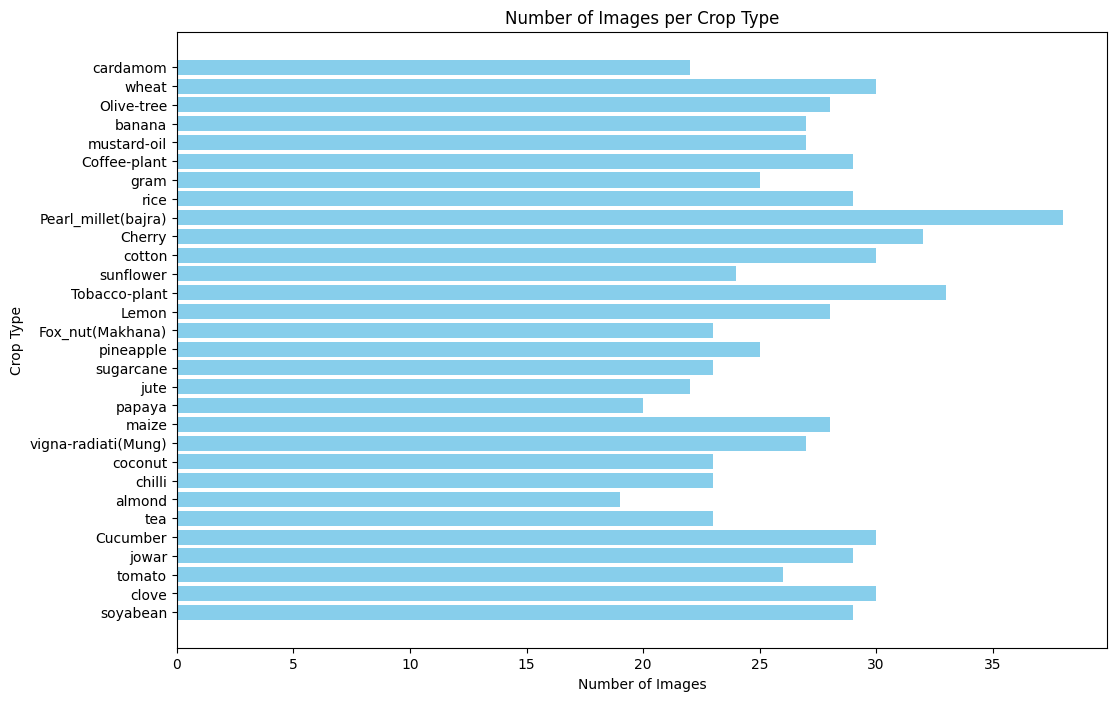

In [74]:
dataset_path = './agricultural_crops/Agricultural-crops'

crop_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

image_counts = {}
for crop_type in crop_types:
    crop_folder = os.path.join(dataset_path, crop_type)
    image_counts[crop_type] = len([f for f in os.listdir(crop_folder) if os.path.isfile(os.path.join(crop_folder, f))])

df = pd.DataFrame(list(image_counts.items()), columns=['Crop Type', 'Image Count'])

plt.figure(figsize=(12, 8))
plt.barh(df['Crop Type'], df['Image Count'], color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Crop Type')
plt.title('Number of Images per Crop Type')
plt.show()


In [11]:
from google.colab import files
import os

# Re-upload model files
uploaded = files.upload()

# List files to check
files_list = os.listdir()
print("Files in the current directory:", files_list)

# Load models with the correct filenames
# Adjust the filenames based on the output of the list command



Saving model_aug.keras to model_aug.keras
Saving model_noaug.keras to model_noaug.keras
Files in the current directory: ['.config', 'model_noaug.keras', 'subset_dataset', 'agricultural-crops-image-classification.zip', 'model_aug.keras', 'agricultural_crops', 'sample_data']


In [12]:
model_noaug = tf.keras.models.load_model('model_noaug.keras')
model_aug = tf.keras.models.load_model('model_aug.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
model_noaug = tf.keras.models.load_model('model_noaug.keras')
model_aug = tf.keras.models.load_model('model_aug.keras')

print("Model NoAug Summary:")
model_noaug.summary()

print("Model Aug Summary:")
model_aug.summary()


Model NoAug Summary:


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_11 (TrueDivide)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_11 (Subtract)               │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,277,201 (8.69 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 12,812 (50.05 KB)

Model Aug Summary:


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_133 (InputLayer)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_50 (TrueDivide)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_50 (Subtract)               │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_99 (Dropout)                 │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_51          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_100 (Dropout)                │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,110 (8.63 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,564 (10.02 KB)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Save and load the simple model
model.save('simple_model.keras')
loaded_model = tf.keras.models.load_model('simple_model.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
#MODEL 2

image_size = (224, 224)
batch_size = 20
num_classes = 2

def load_and_preprocess_data(base_folder, subset=None, use_augmentation=False):
    dataset = tf.keras.utils.image_dataset_from_directory(
        base_folder,
        validation_split=0.2,
        subset=subset,
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    if use_augmentation and subset == "training":
        dataset = dataset.map(
            lambda img, label: (data_augmentation(img, training=True), label),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [16]:
import imghdr
def remove_unknown_image_files(base_folder):
    for root, dirs, files in os.walk(base_folder):
        for file in files:
            file_path = os.path.join(root, file)
            file_type = imghdr.what(file_path)
            if not file_type:
                print(f'Removing invalid file: {file_path}')
                os.remove(file_path)  # Remove the file if its type is unknown

remove_unknown_image_files('./agricultural_crops')

Removing invalid file: ./agricultural_crops/Agricultural-crops/soyabean/imaage (25).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/jowar/image (3).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/Cucumber/image (28).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/almond/image (9).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/almond/image (13).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/coconut/image (14).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/coconut/image (8).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/maize/image (5).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/maize/image (12).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/maize/image (21).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/papaya/image (15).jpg
Removing invalid file: ./agricultural_crops/Agricultural-crops/pap

In [17]:
for images, labels in train_ds.take(1):
    print(labels.numpy())


[0 3 2 1 0 4 2 1 0 0]


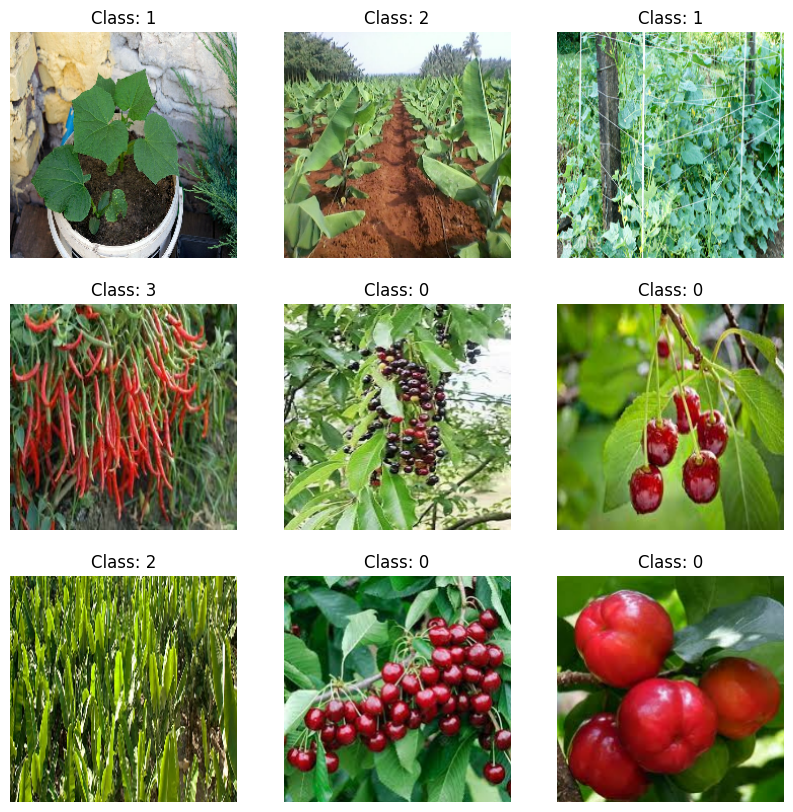

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis("off")
plt.show()


In [20]:
base_folder = './agricultural_crops/Agricultural-crops'
subset_folder = './agricultural_crops/subset_dataset'
classes = ['Cherry', 'banana', 'coconut', 'chilli', 'Cucumber']


os.makedirs(subset_folder, exist_ok=True)

for class_name in classes:
    class_path = os.path.join(base_folder, class_name)
    subset_class_path = os.path.join(subset_folder, class_name)
    if os.path.exists(class_path):
        shutil.copytree(class_path, subset_class_path)
    else:
        print(f'Class {class_name} not found in the base folder.')


Found 135 files belonging to 5 classes.
Using 108 files for training.
Found 135 files belonging to 5 classes.
Using 27 files for validation.


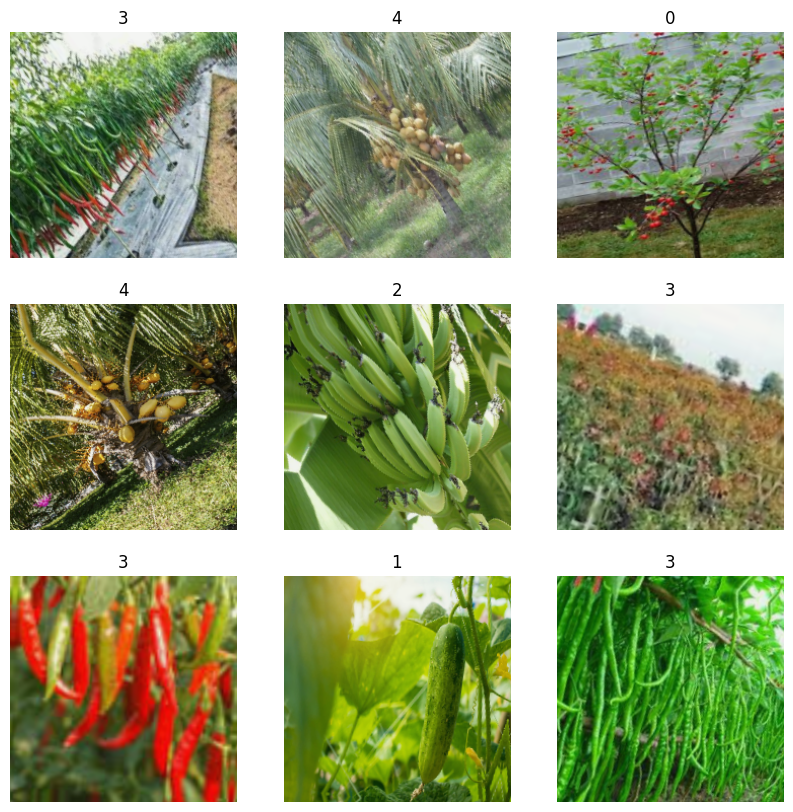

In [29]:
#image and batch size again
image_size = (224, 224)
batch_size = 10
num_classes = 2

def load_and_preprocess_data(base_folder):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_folder,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        base_folder,
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )

#chose these data augmentation layers
    data_augmentation_layers = [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomContrast(0.1),
    ]

    def data_augmentation(images):
        for layer in data_augmentation_layers:
            images = layer(images)
        return images

#this applies it to ds
    train_ds = train_ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

def visualize(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")

train_ds, val_ds = load_and_preprocess_data('./agricultural_crops/subset_dataset')
visualize(train_ds)


In [30]:
from tensorflow.keras.applications import EfficientNetB3

def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of EfficientNetB3 and freeze the weights
    backbone = EfficientNetB3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = keras.applications.efficientnet.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="efficientnetb3_model")

input_shape = image_size + (3,)
num_classes = len(classes)
model = make_transfer_model(input_shape, num_classes)

epochs = 8
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.2445 - loss: 1.6251 - val_acc: 0.4074 - val_loss: 1.4984
Epoch 2/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - acc: 0.3589 - loss: 1.3815 - val_acc: 0.4444 - val_loss: 1.3419
Epoch 3/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - acc: 0.5427 - loss: 1.2035 - val_acc: 0.5556 - val_loss: 1.2085
Epoch 4/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.6598 - loss: 1.1116 - val_acc: 0.7037 - val_loss: 1.0895
Epoch 5/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - acc: 0.7826 - loss: 0.9576 - val_acc: 0.7037 - val_loss: 0.9870
Epoch 6/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - acc: 0.7995 - loss: 0.9173 - val_acc: 0.7778 - val_loss: 0.9017
Epoch 7/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.7983 - loss: 0.8660 - val_acc: 0.8519 - val_loss: 0.8304
Epoch 8/8
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.8873 - loss: 0.6432 - val_acc: 0.9259 - val_loss: 0.7701


In [31]:
def get_predictions_and_labels(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        predictions = model(images, training=False)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.nn.softmax(predictions).numpy())
    return np.array(y_true), np.array(y_pred)


In [24]:
model.summary()

Model: "efficientnetb3_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 1536)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           7,685 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,806,592 (41.22 MB)

 Trainable params: 7,685 (30.02 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

 Optimizer params: 15,372 (60.05 KB)

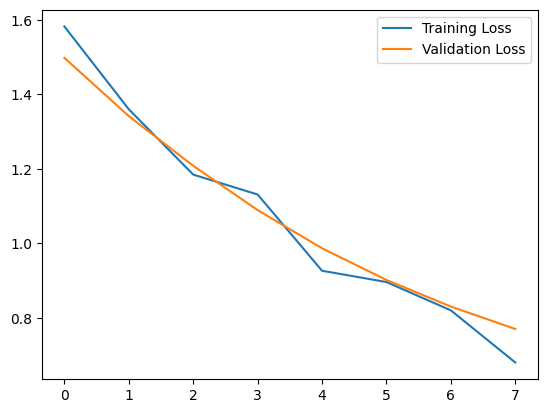

In [32]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

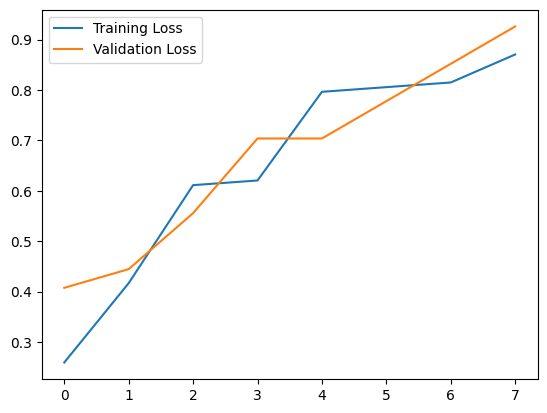

In [33]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

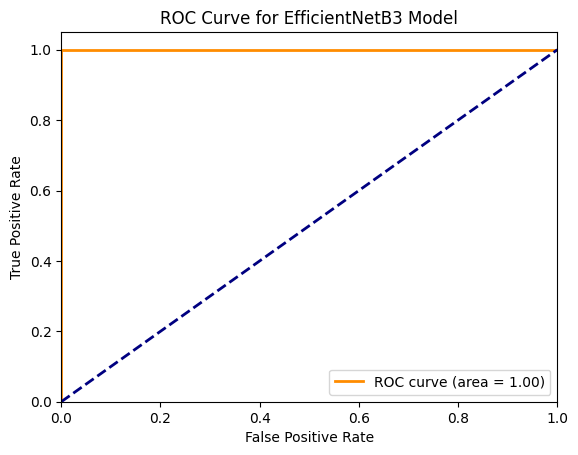

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(y_true, y_pred, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()


y_true, y_pred = get_predictions_and_labels(model, val_ds)

# Plot the ROC curve
plot_roc_curve(y_true, y_pred, title="ROC Curve for EfficientNetB3 Model")



In [25]:
model.save('efficient.keras')

Found 135 files belonging to 5 classes.
Using 108 files for training.
Found 135 files belonging to 5 classes.
Using 27 files for validation.
Epoch 1/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.1516 - loss: 1283.0209 - val_acc: 0.1481 - val_loss: 289.6894
Epoch 2/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.2666 - loss: 107.0552 - val_acc: 0.2593 - val_loss: 77.2726
Epoch 3/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.3568 - loss: 49.6198 - val_acc: 0.3704 - val_loss: 10.1132
Epoch 4/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.4106 - loss: 10.0707 - val_acc: 0.4074 - val_loss: 8.4392
Epoch 5/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.5420 - loss: 5.6486 - val_acc: 0.4074 - val_loss: 5.9773
Epoch 6/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - acc: 0.5652 - loss: 4.0800 - val_acc: 0.4444 - val_loss: 3.8165
Epoch 7/16
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - acc: 0.7390 - loss: 1.2310 - val_acc: 0.3704 - val_loss: 3.5092
Epoch 8/16
11/11 ━━━━━━━━━━━━━━━━━━━

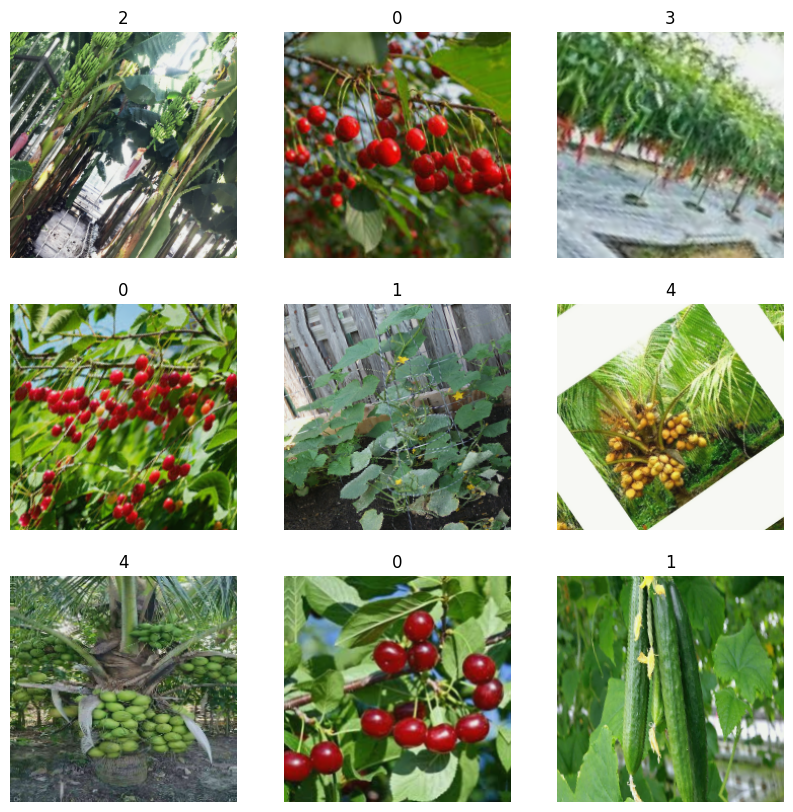

In [41]:
image_size = (224, 224)
batch_size = 15
num_classes = 5

# Load and preprocess data
def load_and_preprocess_data(base_folder):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_folder,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        base_folder,
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )

    # Data augmentation
    data_augmentation_layers = [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomContrast(0.1),
    ]

    def data_augmentation(images):
        for layer in data_augmentation_layers:
            images = layer(images)
        return images

    train_ds = train_ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

def make_simple_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

train_ds, val_ds = load_and_preprocess_data('./agricultural_crops/subset_dataset')

input_shape = image_size + (3,)
model = make_simple_model(input_shape, num_classes)
model.compile(
    optimizer=optimizers.Adam(3e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[metrics.SparseCategoricalAccuracy(name="acc")],
)

epochs = 16
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

def visualize(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")

visualize(train_ds)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - acc: 0.5903 - loss: 1.5483
Test accuracy: 0.5555555820465088


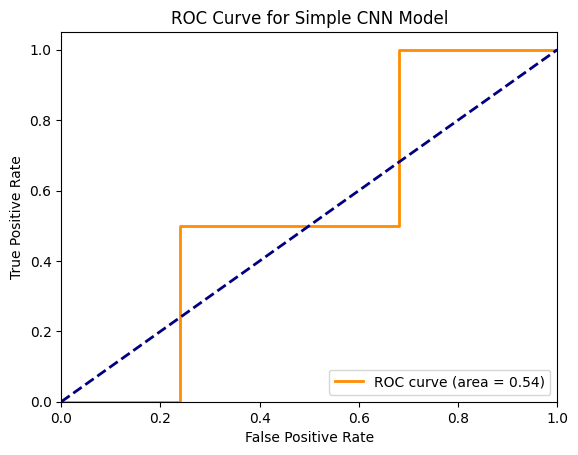

In [42]:
test_loss, test_acc = model.evaluate(val_ds)
print(f'Test accuracy: {test_acc}')
y_true, y_pred = get_predictions_and_labels(model, val_ds)

plot_roc_curve(y_true, y_pred, title="ROC Curve for Simple CNN Model")

Found 135 files belonging to 5 classes.
Using 108 files for training.
Found 135 files belonging to 5 classes.
Using 27 files for validation.
Epoch 1/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - acc: 0.2527 - loss: 1.5689 - val_acc: 0.3333 - val_loss: 1.3638
Epoch 2/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - acc: 0.3448 - loss: 1.4683 - val_acc: 0.5926 - val_loss: 1.2359
Epoch 3/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - acc: 0.5781 - loss: 1.2651 - val_acc: 0.7407 - val_loss: 1.1198
Epoch 4/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - acc: 0.6804 - loss: 1.1467 - val_acc: 0.8148 - val_loss: 1.0300
Epoch 5/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - acc: 0.8122 - loss: 0.9798 - val_acc: 0.8519 - val_loss: 0.9556
Epoch 6/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - acc: 0.7439 - loss: 0.9619 - val_acc: 0.8519 - val_loss: 0.8923
Epoch 7/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - acc: 0.7563 - loss: 0.8698 - val_acc: 0.8889 - val_loss: 0.8293
Epoch 8/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - acc: 0.7328 - loss:

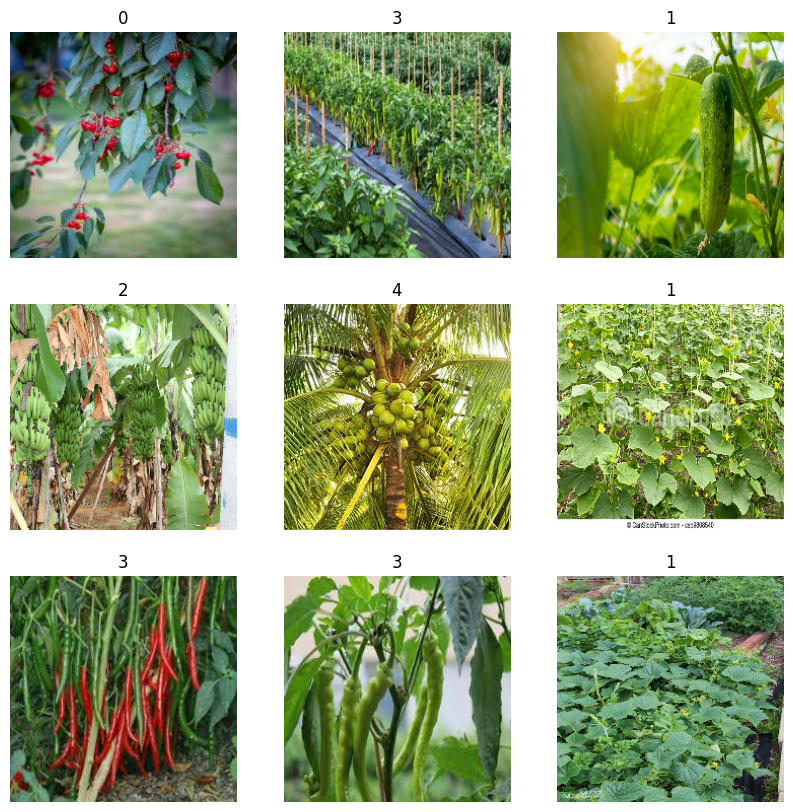

In [80]:
#NO AUGMENTATION
image_size = (224, 224)
batch_size = 15
num_classes = 5

def load_and_preprocess_data(base_folder):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_folder,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        base_folder,
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )

#so this code aint got data augmentation
    return train_ds, val_ds

train_ds, val_ds = load_and_preprocess_data('./agricultural_crops/subset_dataset')

def make_transfer_model(input_shape, num_classes):
    backbone = tf.keras.applications.EfficientNetB3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False  #this initially freezes model

    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = backbone(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="efficientnetb3_finetune")

input_shape = image_size + (3,)
model = make_transfer_model(input_shape, num_classes)

model.compile(
    optimizer=optimizers.Adam(3e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[metrics.SparseCategoricalAccuracy(name="acc")],
)

epochs = 8
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

#so this unfreezes some of the layers to help
backbone = model.get_layer('efficientnetb3')
for layer in backbone.layers[-20:]:  #last 20 layers
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(1e-5),  #lower learning rate for fine-tuning
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[metrics.SparseCategoricalAccuracy(name="acc")],
)

#keeps on training the model and finetuing it
fine_tune_epochs = 8
total_epochs = epochs + fine_tune_epochs
history_finetune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
)

def visualize(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")

visualize(train_ds)



In [81]:
model.save('ewithout.keras')

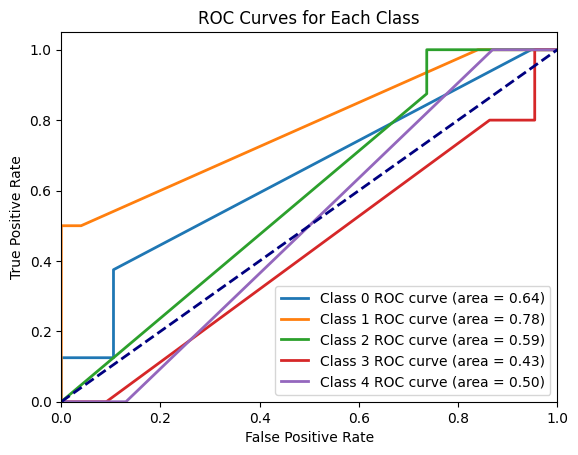

In [47]:
def get_predictions_and_labels(model, dataset):
    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted probabilities
    for images, labels in dataset:
        predictions = model(images, training=False)  # Get model predictions
        y_true.extend(labels.numpy())  # Append true labels
        y_pred.extend(tf.nn.softmax(predictions).numpy())  # Append predicted probabilities
    return np.array(y_true), np.array(y_pred)  # Return true labels and predicted probabilities as numpy arrays

y_true, y_pred = get_predictions_and_labels(model, val_ds)


fpr = dict()  # Dictionary to store false positive rates
tpr = dict()  # Dictionary to store true positive rates
roc_auc = dict()  # Dictionary to store ROC AUC scores
for i in range(num_classes):  # Iterate over each class
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])  # Compute ROC curve
    roc_auc[i] = auc(fpr[i], tpr[i])  # Compute ROC AUC score


plt.figure()
for i in range(num_classes):  # Iterate over each class
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()


Found 135 files belonging to 5 classes.
Using 108 files for training.
Found 135 files belonging to 5 classes.
Using 27 files for validation.
Epoch 1/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.2276 - loss: 664.7026 - val_acc: 0.2963 - val_loss: 227.2418
Epoch 2/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - acc: 0.1750 - loss: 309.7937 - val_acc: 0.1852 - val_loss: 94.0818
Epoch 3/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.2352 - loss: 110.2282 - val_acc: 0.1111 - val_loss: 14.0834
Epoch 4/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - acc: 0.2525 - loss: 21.4774 - val_acc: 0.3333 - val_loss: 6.6423
Epoch 5/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.3149 - loss: 5.4313 - val_acc: 0.2593 - val_loss: 3.6419
Epoch 6/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.3334 - loss: 3.8590 - val_acc: 0.2222 - val_loss: 3.5659
Epoch 7/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - acc: 0.2034 - loss: 3.6428 - val_acc: 0.1481 - val_loss: 3.6004
Epoch 8/16
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - 

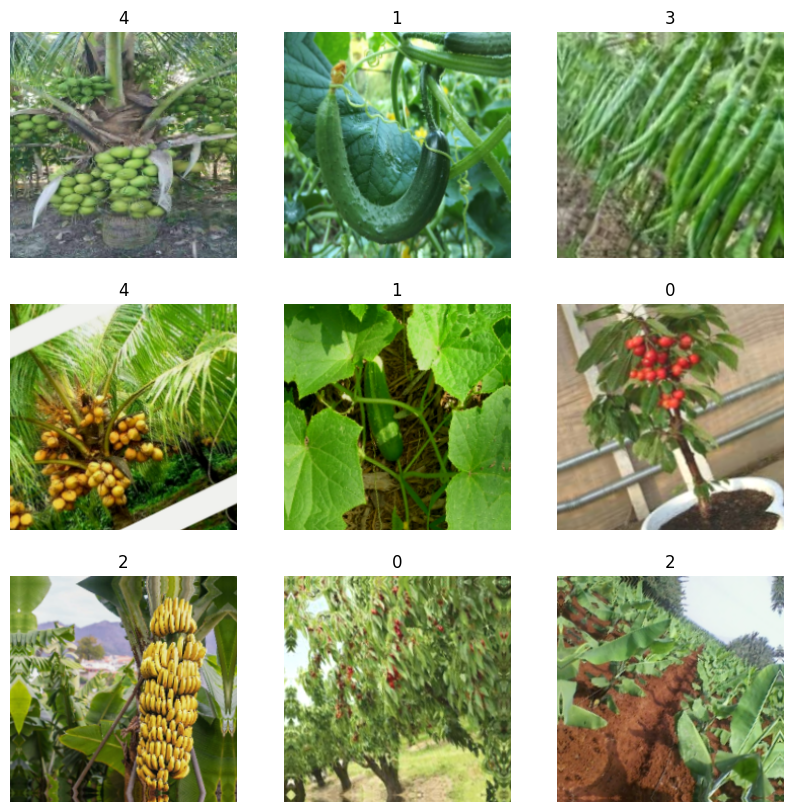

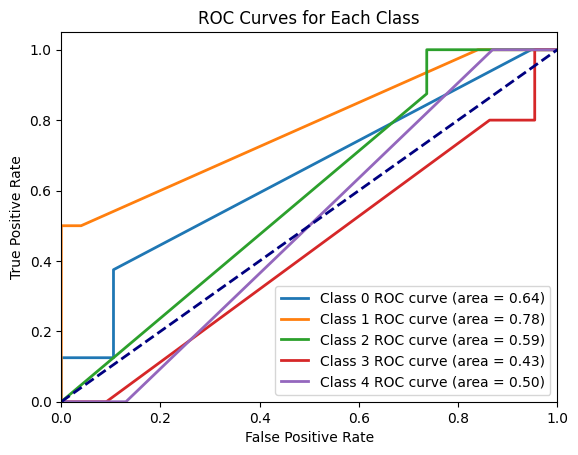

In [46]:
image_size = (224, 224)
batch_size = 15
num_classes = 5

def load_and_preprocess_data(base_folder):
    #training dataset with 80% of data for training
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_folder,
        validation_split=0.2,  # Split the data into 80% training and 20% validation
        subset="training",  # Use this subset for training
        seed=1337,  # Seed for reproducibility
        image_size=image_size,  # Resize images to the specified size
        batch_size=batch_size,  # Number of images in each batch
    )
    # 20% of data for validation
    val_ds = tf.keras.utils.image_dataset_from_directory(
        base_folder,
        validation_split=0.2,  # Split the data into 80% training and 20% validation
        subset="validation",  # Use this subset for validation
        seed=1337,  # Seed for reproducibility
        image_size=image_size,  # Resize images to the specified size
        batch_size=batch_size,  # Number of images in each batch
    )

    #llayers
    data_augmentation_layers = [
        layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
        layers.RandomRotation(0.1),  # Randomly rotate images by up to 10%
        layers.RandomContrast(0.1),  # Randomly adjust image contrast by up to 10%
        layers.RandomZoom(0.1),  # Randomly zoom in on images by up to 10%
        layers.RandomBrightness(0.1)  # Randomly adjust image brightness by up to 10%
    ]

    #data augmentation
    def data_augmentation(images):
        for layer in data_augmentation_layers:
            images = layer(images)  # Apply each augmentation layer
        return images

    # da to training dataset
    train_ds = train_ds.map(
        lambda img, label: (data_augmentation(img), label),  # Apply augmentation function
        num_parallel_calls=tf.data.AUTOTUNE,  # Parallelize data processing
    )
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)  # Prefetch data to improve performance
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)  # Prefetch data to improve performance

    return train_ds, val_ds  # Return the augmented training and validation datasets

# Build a simple model
def make_simple_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),  # Input layer with the specified shape
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Convolutional layer with 32 filters and L2 regularization
        layers.MaxPooling2D(),  # Max pooling layer
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Convolutional layer with 64 filters and L2 regularization
        layers.MaxPooling2D(),  # Max pooling layer
        layers.Flatten(),  # Flatten the output from convolutional layers
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Dense layer with 128 units and L2 regularization
        layers.Dropout(0.5),  # Dropout layer with 50% dropout rate
        layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
    ])
    return model

train_ds, val_ds = load_and_preprocess_data('./agricultural_crops/subset_dataset')  # Load and preprocess data from the specified folder

# create the model
input_shape = image_size + (3,)  # Define input shape with 3 color channels (RGB)
model = make_simple_model(input_shape, num_classes)  # Create the model
model.compile(
    optimizer=optimizers.Adam(3e-4),  # Adam optimizer with a learning rate of 0.0003
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),  # Loss function for sparse categorical classification
    metrics=[metrics.SparseCategoricalAccuracy(name="acc")],  # Metrics to track accuracy
)

# so this whole thing for stopping overfitting by checking the validation loss levels at each epoch
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore the best weights when stopping
)

# Model training time!!!
epochs = 16  # Number of training epochs
history = model.fit(
    train_ds,  # Training dataset
    epochs=epochs,  # Number of epochs
    validation_data=val_ds,  # Validation dataset
    callbacks=[early_stopping]  # List of callbacks
)

# Visualize some examples from the training dataset
def visualize(dataset):
    plt.figure(figsize=(10, 10))  # Create a figure with specified size
    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(9):  # Display 9 images
            ax = plt.subplot(3, 3, i + 1)  # Create a subplot for each image
            plt.imshow(images[i].numpy().astype("uint8"))  # Display image
            plt.title(int(labels[i]))  # Set the title with the label
            plt.axis("off")  # Turn off axis

visualize(train_ds)  # Call the visualize function to display images


def get_predictions_and_labels(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        predictions = model(images, training=False)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.nn.softmax(predictions).numpy())
    return np.array(y_true), np.array(y_pred)  # Return true labels and predicted probabilities as numpy arrays


y_true, y_pred = get_predictions_and_labels(model, val_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()


In [78]:
model.save('ewith.keras')

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def calculate_metrics(y_true, y_pred, num_classes):
#convert predictions to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true, y_pred_labels)
    precision = precision_score(y_true, y_pred_labels, average='weighted')
    recall = recall_score(y_true, y_pred_labels, average='weighted')
    f1 = f1_score(y_true, y_pred_labels, average='weighted')
    roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')

    return accuracy, precision, recall, f1, roc_auc



In [86]:
from tensorflow.keras.models import load_model

# Load the models
ewith = load_model('ewith.keras')
ewithout = load_model('ewithout.keras')


In [100]:
y_true_eff, y_pred_eff = get_predictions_and_labels(ewith, val_ds)
y_true_eff_fine, y_pred_eff_fine = get_predictions_and_labels(ewithout, val_ds)
#wasn't working and i reloaded it here??

In [92]:
def convert_to_one_hot(y_true, num_classes):
    return np.eye(num_classes)[y_true]
y_true_one_hot = convert_to_one_hot(y_true, num_classes_pred)


In [106]:
from sklearn.metrics import roc_auc_score, classification_report

def calculate_metrics(y_true, y_pred, num_classes):
    y_true_one_hot = adjust_y_true(y_true, y_pred.shape[1])

    roc_auc = roc_auc_score(y_true_one_hot, y_pred, multi_class='ovr')


    report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=[f'Class {i}' for i in range(num_classes)], output_dict=True)

    metrics = {
        'ROC-AUC': roc_auc,
        'Accuracy': report['accuracy'],
        'Precision': np.mean([report[f'Class {i}']['precision'] for i in range(num_classes)]),
        'Recall': np.mean([report[f'Class {i}']['recall'] for i in range(num_classes)]),
        'F1-Score': np.mean([report[f'Class {i}']['f1-score'] for i in range(num_classes)])
    }m

    return metrics


In [89]:
import numpy as np

unique_classes_true = np.unique(y_true)
num_classes_pred = y_pred.shape[1]

print("Unique classes in y_true:", unique_classes_true)
print("Number of columns in y_pred:", num_classes_pred)


Unique classes in y_true: [0 1 2 3 4]
Number of columns in y_pred: 5
